In [0]:
pip install haversine

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
from pyspark.sql import SparkSession

In [0]:
spark=SparkSession.builder.appName("Datasetexploration").getOrCreate()

In [0]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.0 
 Master 
 local[8] 
 AppName 
 Databricks Shell

In [0]:
from pyspark.sql.types import StructType,StructField, StringType, IntegerType 
from pyspark.sql.types import ArrayType, DoubleType, BooleanType
from pyspark.sql.functions import col,array_contains

In [0]:
#df = spark.read.table("dataset_2017_fordgobike_tripdata_1_csv")

df = spark.read.option("header","true").csv("/FileStore/Dataset_2017_fordgobike_tripdata.csv")
#df = spark.read.csv("/home/julian/FORD_GO_BIKE_PROJECT/Dataset-2017-fordgobike-tripdata.csv",header=True)

In [0]:
df.show(3)

+----------+--------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+-------+---------+-----------------+-------------+-----------+
|start_time|end_time|start_station_id|  start_station_name|start_station_latitude|start_station_longitude|end_station_id|    end_station_name|end_station_latitude|end_station_longitude|bike_id|user_type|member_birth_year|member_gender|     pyment|
+----------+--------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+-------+---------+-----------------+-------------+-----------+
|   57:39.7| 12:50.2|              74|Laguna St at Haye...|           37.77643482|            -122.426244|            43|San Francisco Pub...|          37.7787677|         -122.4159292|     96| Customer|             1987|         Male|credit card|
|   56:3

In [0]:
df.printSchema()

root
 |-- start_time: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: string (nullable = true)
 |-- start_station_longitude: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: string (nullable = true)
 |-- end_station_longitude: string (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: string (nullable = true)
 |-- member_gender: string (nullable = true)
 |-- pyment: string (nullable = true)



### a) Taking care of duplicates

In [0]:
df.count()==df.drop_duplicates().count()

Out[8]: True

##### We can observe that there no duplicates in our dataset

In [0]:
df.drop_duplicates().count()

Out[9]: 519700

### b) Taking care of null values

In [0]:
total_count = df.count()

In [0]:
df.where(col("member_gender").isNull()).count()

Out[11]: 66462

In [0]:
df.filter(col("member_gender").isNull()).count()

Out[12]: 66462

In [0]:
for column in df.columns:
    null_count = df.filter(col(column).isNull()).count()
    print(f'the number of null values in {column} is {null_count} representing {round(null_count/total_count,2)} % of the total data')

the number of null values in start_time is 0 representing 0.0 % of the total data
the number of null values in end_time is 0 representing 0.0 % of the total data
the number of null values in start_station_id is 0 representing 0.0 % of the total data
the number of null values in start_station_name is 0 representing 0.0 % of the total data
the number of null values in start_station_latitude is 0 representing 0.0 % of the total data
the number of null values in start_station_longitude is 0 representing 0.0 % of the total data
the number of null values in end_station_id is 0 representing 0.0 % of the total data
the number of null values in end_station_name is 0 representing 0.0 % of the total data
the number of null values in end_station_latitude is 0 representing 0.0 % of the total data
the number of null values in end_station_longitude is 0 representing 0.0 % of the total data
the number of null values in bike_id is 0 representing 0.0 % of the total data
the number of null values in user

##### From the above calculations we can see that only two columns: 'member_birth_year' and 'member_gender' are having null values, and both representing 0.13 %  of the total data .
##### Thus these columns can confidently be dropped

In [0]:
df = df.na.drop()

In [0]:
df.count()

Out[15]: 453159

### c) Looking at unique values in some features

In [0]:
df.printSchema()

root
 |-- start_time: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: string (nullable = true)
 |-- start_station_longitude: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: string (nullable = true)
 |-- end_station_longitude: string (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: string (nullable = true)
 |-- member_gender: string (nullable = true)
 |-- pyment: string (nullable = true)



#### c1) columns 'start_station_id' and 'end_station_id' as well as 'start_station_name' and 'end_station_name'

In [0]:
df.select('start_station_id').distinct().count()

Out[17]: 272

In [0]:
df.select('end_station_id').distinct().count()

Out[18]: 272

In [0]:
df.select('start_station_name').distinct().count()

Out[19]: 272

In [0]:
df.select('end_station_name').distinct().count()

Out[20]: 272

##### From the above we can notice that there are 272 stations in total

#### c2) Column 'bike_id'

In [0]:
df.select('bike_id').distinct().count()

Out[21]: 3670

##### From the above we can notice that there are 3670 different bikes being used  in total

#### c3) Column 'user_type', 'member_gender' and 'pyment'

In [0]:
df.select('user_type').distinct().show()

+----------+
| user_type|
+----------+
|Subscriber|
|  Customer|
+----------+



##### There are two groups of user Customers and Subscribers

In [0]:
df.select('member_gender').distinct().show()

+-------------+
|member_gender|
+-------------+
|       Female|
|        Other|
|         Male|
+-------------+



##### There are three gender groups: Male,Female and Others

In [0]:
df.select('pyment').distinct().show()

+-----------+
|     pyment|
+-----------+
| app wallet|
|credit card|
+-----------+



##### There are two paymrnt modes: app_wallet and credit card

#### C4) Columns: 'member_birth_year'

In [0]:
df.select('member_birth_year').distinct().count()

Out[25]: 73

In [0]:
df.filter(df['member_birth_year'] < 1950).select('member_birth_year').distinct().show()

+-----------------+
|member_birth_year|
+-----------------+
|             1943|
|             1938|
|             1911|
|             1941|
|             1940|
|             1946|
|             1942|
|             1935|
|             1947|
|             1924|
|             1900|
|             1944|
|             1902|
|             1934|
|             1948|
|             1949|
|             1928|
|             1945|
|             1933|
|             1901|
+-----------------+
only showing top 20 rows



In [0]:
for column in df.columns:
    null_count = df.filter(col(column).isNull()).count()
    print(f'the number of null values in {column} is {null_count} representing {round(null_count/total_count,2)} % of the total data')

the number of null values in start_time is 0 representing 0.0 % of the total data
the number of null values in end_time is 0 representing 0.0 % of the total data
the number of null values in start_station_id is 0 representing 0.0 % of the total data
the number of null values in start_station_name is 0 representing 0.0 % of the total data
the number of null values in start_station_latitude is 0 representing 0.0 % of the total data
the number of null values in start_station_longitude is 0 representing 0.0 % of the total data
the number of null values in end_station_id is 0 representing 0.0 % of the total data
the number of null values in end_station_name is 0 representing 0.0 % of the total data
the number of null values in end_station_latitude is 0 representing 0.0 % of the total data
the number of null values in end_station_longitude is 0 representing 0.0 % of the total data
the number of null values in bike_id is 0 representing 0.0 % of the total data
the number of null values in user

In [0]:
#df1 = copy.deepcopy(X.schema)

In [0]:
df1 = df

In [0]:
df1.printSchema()

root
 |-- start_time: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: string (nullable = true)
 |-- start_station_longitude: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: string (nullable = true)
 |-- end_station_longitude: string (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: string (nullable = true)
 |-- member_gender: string (nullable = true)
 |-- pyment: string (nullable = true)



In [0]:
df1.filter(df1['member_birth_year'].isNull()).count()

Out[31]: 0

## 1. Looking for a way of getting the distance travelled for each trip

In [0]:

df1 = df1.withColumn('start_station_latitude',df['start_station_latitude'].cast("double")).\
         withColumn('start_station_longitude',df['start_station_longitude'].cast("double")).\
        withColumn('end_station_latitude',df['end_station_latitude'].cast("double")).\
        withColumn('end_station_longitude',df['end_station_longitude'].cast("double"))

In [0]:
df1.printSchema()

root
 |-- start_time: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: double (nullable = true)
 |-- start_station_longitude: double (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: double (nullable = true)
 |-- end_station_longitude: double (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: string (nullable = true)
 |-- member_gender: string (nullable = true)
 |-- pyment: string (nullable = true)



In [0]:
import haversine
from haversine import haversine, Unit


In [0]:
from pyspark.sql.functions import udf , round
from pyspark.sql.types import StringType,DoubleType
# defining the function you want 
def distance(lat1,long1,lat2,long2):
    loc1 = (lat1,long1)
    loc2 = (lat2,long2)
    distance1 =haversine(loc1,loc2, Unit.KILOMETERS)
    return distance1

distanceUDF = udf(distance , DoubleType())

In [0]:
df1 = df1.withColumn("distance_travelled", distanceUDF(df1['start_station_latitude'],df1['start_station_longitude'],df1['end_station_latitude'] ,df1['end_station_longitude']))#.select('distance_travelled').show()
                                #.withColumn('distance_travelled',round(df1['distance_travelled'],2)).select('distance_travelled').show()                                                            
                        

In [0]:
df1.printSchema()

root
 |-- start_time: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: double (nullable = true)
 |-- start_station_longitude: double (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: double (nullable = true)
 |-- end_station_longitude: double (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: string (nullable = true)
 |-- member_gender: string (nullable = true)
 |-- pyment: string (nullable = true)
 |-- distance_travelled: double (nullable = true)



In [0]:
df1 = df1.withColumn('distance_travelled',round(df1['distance_travelled'],2))#.select('distance_travelled').show() 

In [0]:
df1.select('distance_travelled').show() 

+------------------+
|distance_travelled|
+------------------+
|              0.94|
|              3.07|
|              0.64|
|               0.0|
|              1.52|
|              1.52|
|              1.05|
|              1.05|
|              2.86|
|              2.86|
|              0.88|
|              1.81|
|              0.62|
|              0.62|
|              1.79|
|              1.86|
|              0.34|
|              0.91|
|              0.75|
|              1.96|
+------------------+
only showing top 20 rows



## 2. let us now see if we can get the time taken by each trip

#### Let us first find a way of organising the start and end time column to a proper format

In [0]:
df1.select('start_time','end_time').printSchema()

root
 |-- start_time: string (nullable = true)
 |-- end_time: string (nullable = true)



In [0]:
from pyspark.sql.functions import udf
def attachinghour(mystring):
    onehour = '01:'
    good_format = onehour+mystring
    return good_format
attachinghourUDF = udf(lambda x : attachinghour(x))

In [0]:
df1 = df1.withColumn('start_time', attachinghourUDF(df1['start_time'])).withColumn('end_time', attachinghourUDF(df1['end_time']))#.select('start_time','end_time').show(5)

In [0]:
from pyspark.sql.types import StringType,DoubleType
# defining the function you want 
def moving_up_thehour(starttime,endtime):
    if starttime[3:5] > endtime[3:5]:
        return endtime.replace(endtime[0:2],'02')
    else:
        return endtime

moving_hour_UDF = udf(moving_up_thehour , StringType())

In [0]:
df1 = df1.withColumn("end_time", moving_hour_UDF(df1['start_time'],df1['end_time']))#.select('start_time','end_time').show(10)

In [0]:
df1.select('start_time','end_time').show(10)

+----------+----------+
|start_time|  end_time|
+----------+----------+
|01:57:39.7|02:12:50.2|
|01:56:34.8|02:49:55.6|
|01:23:14.0|01:29:57.6|
|01:49:28.4|02:04:35.6|
|01:52:55.6|02:29:18.7|
|01:52:55.9|02:29:06.9|
|01:53:38.9|02:19:23.0|
|01:54:40.1|02:19:14.4|
|01:52:49.5|02:18:22.0|
|01:46:34.0|02:06:50.1|
+----------+----------+
only showing top 10 rows



In [0]:
from pyspark.sql.functions import *
df1 = df1.withColumn('start_time', to_timestamp(col('start_time'),"HH:mm:ss.SSS"))\
    .withColumn('end_time', to_timestamp(col('end_time'),"HH:mm:ss.SSS"))

In [0]:
df1.printSchema()

root
 |-- start_time: timestamp (nullable = true)
 |-- end_time: timestamp (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: double (nullable = true)
 |-- start_station_longitude: double (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: double (nullable = true)
 |-- end_station_longitude: double (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: string (nullable = true)
 |-- member_gender: string (nullable = true)
 |-- pyment: string (nullable = true)
 |-- distance_travelled: double (nullable = true)



In [0]:
df1.withColumn('trip_time', df1['start_time'] - df1['end_time']).select('trip_time').show(truncate=False)
# From the obtained results this method will not probably work

+--------------------------------------+
|trip_time                             |
+--------------------------------------+
|INTERVAL '-0 00:15:10.5' DAY TO SECOND|
|INTERVAL '-0 00:53:20.8' DAY TO SECOND|
|INTERVAL '-0 00:06:43.6' DAY TO SECOND|
|INTERVAL '-0 00:15:07.2' DAY TO SECOND|
|INTERVAL '-0 00:36:23.1' DAY TO SECOND|
|INTERVAL '-0 00:36:11' DAY TO SECOND  |
|INTERVAL '-0 00:25:44.1' DAY TO SECOND|
|INTERVAL '-0 00:24:34.3' DAY TO SECOND|
|INTERVAL '-0 00:25:32.5' DAY TO SECOND|
|INTERVAL '-0 00:20:16.1' DAY TO SECOND|
|INTERVAL '-0 00:06:26.5' DAY TO SECOND|
|INTERVAL '-0 00:08:02.1' DAY TO SECOND|
|INTERVAL '-0 00:14:31.3' DAY TO SECOND|
|INTERVAL '-0 00:12:13.6' DAY TO SECOND|
|INTERVAL '-0 00:13:02' DAY TO SECOND  |
|INTERVAL '-0 00:07:55.3' DAY TO SECOND|
|INTERVAL '-0 00:02:32.1' DAY TO SECOND|
|INTERVAL '-0 00:04:09.5' DAY TO SECOND|
|INTERVAL '-0 00:04:03' DAY TO SECOND  |
|INTERVAL '-0 00:13:53' DAY TO SECOND  |
+--------------------------------------+
only showing top

In [0]:
#Another approach to get the duration in minutes
df1 = df1.withColumn('trip_duration_seconds',col("end_time").cast("long") - col('start_time').cast("long"))#.select('trip_duration_seconds').show(10,truncate=False)
# got results obtained

In [0]:
# adding the duration in minutes
df1 = df1.withColumn('trip_duration_minutes',round((col("end_time").cast("long") - col('start_time').cast("long"))/60))#.select('trip_duration_minutes').show(10,truncate=False)


In [0]:
df1.printSchema()

root
 |-- start_time: timestamp (nullable = true)
 |-- end_time: timestamp (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: double (nullable = true)
 |-- start_station_longitude: double (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: double (nullable = true)
 |-- end_station_longitude: double (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: string (nullable = true)
 |-- member_gender: string (nullable = true)
 |-- pyment: string (nullable = true)
 |-- distance_travelled: double (nullable = true)
 |-- trip_duration_seconds: long (nullable = true)
 |-- trip_duration_minutes: double (nullable = true)



##### Let us try using the SQL syntax

In [0]:
df1.createOrReplaceTempView('df1')

In [0]:
spark.sql('SELECT * FROM df1 ').show()


+--------------------+--------------------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+-------+----------+-----------------+-------------+-----------+------------------+---------------------+---------------------+
|          start_time|            end_time|start_station_id|  start_station_name|start_station_latitude|start_station_longitude|end_station_id|    end_station_name|end_station_latitude|end_station_longitude|bike_id| user_type|member_birth_year|member_gender|     pyment|distance_travelled|trip_duration_seconds|trip_duration_minutes|
+--------------------+--------------------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+-------+----------+-----------------+-------------+-----------+------------------+---------------------+---------------------

In [0]:
spark.sql('SELECT  TIMESTAMPDIFF(SECOND, start_time, end_time) AS trip_duration_seconds FROM df1;').select('trip_duration_seconds').show(10)

+---------------------+
|trip_duration_seconds|
+---------------------+
|                  910|
|                 3200|
|                  403|
|                  907|
|                 2183|
|                 2171|
|                 1544|
|                 1474|
|                 1532|
|                 1216|
+---------------------+
only showing top 10 rows



In [0]:
spark.sql('SELECT TIMESTAMPDIFF(MINUTE, start_time, end_time) AS trip_time_minutes FROM df1;').select('trip_time_minutes').show(10)

+-----------------+
|trip_time_minutes|
+-----------------+
|               15|
|               53|
|                6|
|               15|
|               36|
|               36|
|               25|
|               24|
|               25|
|               20|
+-----------------+
only showing top 10 rows



## 3. Let us now get the cost for each trip by assuming that the cost is 0.35 cent per minute

In [0]:
df1.printSchema()

root
 |-- start_time: timestamp (nullable = true)
 |-- end_time: timestamp (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: double (nullable = true)
 |-- start_station_longitude: double (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: double (nullable = true)
 |-- end_station_longitude: double (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: string (nullable = true)
 |-- member_gender: string (nullable = true)
 |-- pyment: string (nullable = true)
 |-- distance_travelled: double (nullable = true)
 |-- trip_duration_seconds: long (nullable = true)
 |-- trip_duration_minutes: double (nullable = true)



In [0]:
df1 = df1.withColumn('trip_fee(cents)', round(df1['trip_duration_minutes']*0.35,2))#.select('trip_fee(cents)').show(10)

In [0]:
df1.select('trip_fee(cents)').show(10)

+---------------+
|trip_fee(cents)|
+---------------+
|           5.25|
|          18.55|
|           2.45|
|           5.25|
|           12.6|
|           12.6|
|            9.1|
|           8.75|
|            9.1|
|            7.0|
+---------------+
only showing top 10 rows



In [0]:
df1.printSchema()

root
 |-- start_time: timestamp (nullable = true)
 |-- end_time: timestamp (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: double (nullable = true)
 |-- start_station_longitude: double (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: double (nullable = true)
 |-- end_station_longitude: double (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: string (nullable = true)
 |-- member_gender: string (nullable = true)
 |-- pyment: string (nullable = true)
 |-- distance_travelled: double (nullable = true)
 |-- trip_duration_seconds: long (nullable = true)
 |-- trip_duration_minutes: double (nullable = true)
 |-- trip_fee(cents): double (nullable = true)



## 4. Let us now add the age column for each rider

In [0]:
from pyspark.sql.functions import current_date, year,round


In [0]:
df1 = df1.withColumn('member_age', year(current_date()) - df1['member_birth_year'])#.select('member_age').show()

In [0]:
from pyspark.sql.types import IntegerType,BooleanType,DateType


In [0]:
df1 = df1.withColumn('member_age',df1.member_age.cast('int'))#.printSchema()

In [0]:
df1.count()

Out[64]: 453159

# EXPLORING RIDERS AGE

In [0]:
df1.select('member_age').summary("count", "min", "25%", "75%",'99%', "max").show()

+-------+----------+
|summary|member_age|
+-------+----------+
|  count|    453159|
|    min|        24|
|    25%|        35|
|    75%|        49|
|    99%|        72|
|    max|       137|
+-------+----------+



In [0]:
df1.filter(df1['member_age']>72).count()

Out[66]: 3925

In [0]:
age_dist = df1.groupBy('member_age').agg({'member_age':'count'}).orderBy('count(member_age)', ascending=False)#.show()

In [0]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import seaborn as sns  # visualization tool

In [0]:
age_dist = age_dist.select('*').toPandas()

In [0]:
top_age_dist = age_dist.head(10)

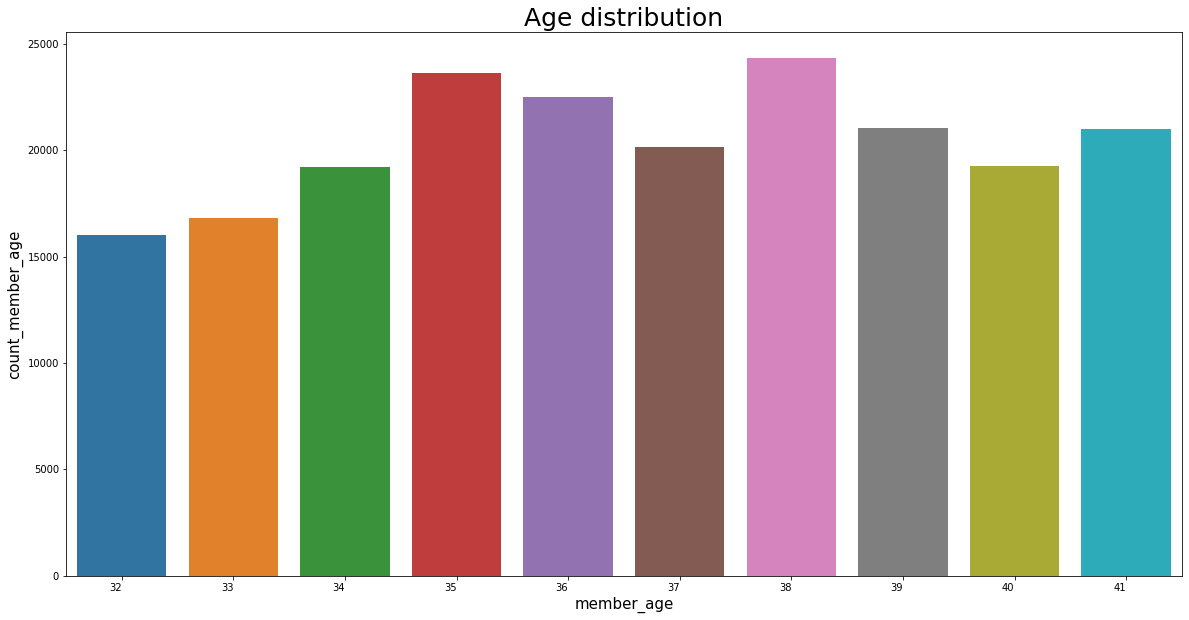

In [0]:
plt.figure(figsize=(20,10))
graph = sns.barplot(x = top_age_dist['member_age'], y = top_age_dist['count(member_age)'], palette= "tab10")
graph.set_title("Age distribution", fontsize = 25)
plt.xlabel('member_age', size=15)
plt.ylabel('count_member_age', size=15)
graph.set_xticklabels(graph.get_xticklabels(), rotation= 0, horizontalalignment='right',);

## Ride rentals vs age_group

In [0]:
## Generate a new field for member age group from member_age_bin
age_dist['member_age_bins'] = age_dist['member_age'].apply(lambda x: '10 - 20' if 10 < x <=20
                                                  else '20 - 30' if 20 < x <= 30
                                                  else '30 - 40' if 30 < x <= 40
                                                  else '40 - 50' if 40 < x <= 50
                                                  else '50 - 60' if 50 < x <= 60
                                                  else '60+' if 60 < x
                                                  else x)

In [0]:
age_dist

,member_age,count(member_age),member_age_bins
0,38,24342,30 - 40
1,35,23610,30 - 40
2,36,22493,30 - 40
3,39,21061,30 - 40
4,41,21005,40 - 50
...,...,...,...
68,85,22,60+
69,112,12,60+
70,116,7,60+
71,122,4,60+


In [0]:
df1_pandas = df1.select('*').toPandas()

In [0]:
## Generate a new field for member age group from member_age_bin
df1_pandas['member_age_bins'] = df1_pandas['member_age'].apply(lambda x: '10 - 20' if 10 < x <=20
                                                  else '20 - 30' if 20 < x <= 30
                                                  else '30 - 40' if 30 < x <= 40
                                                  else '40 - 50' if 40 < x <= 50
                                                  else '50 - 60' if 50 < x <= 60
                                                  else '60+' if 60 < x
                                                  else x)

In [0]:
from pyspark.sql.functions import udf
def age_grouping(age):
    if 20 < age <= 30:
        return '20 - 30'
    elif 30 < age <= 40:
        return '30 - 40'
    elif 40 < age <= 50:
        return '40 - 50'
    elif 50 < age <= 60:
        return '50 - 60'
    else:
        return '60+'
    
age_groupUDF = udf(lambda x : age_grouping(x))
    
    
    

In [0]:
df1 = df1.withColumn('member_age_bins' , age_groupUDF(df1['member_age']))#.select('member_age_bins').show(3)

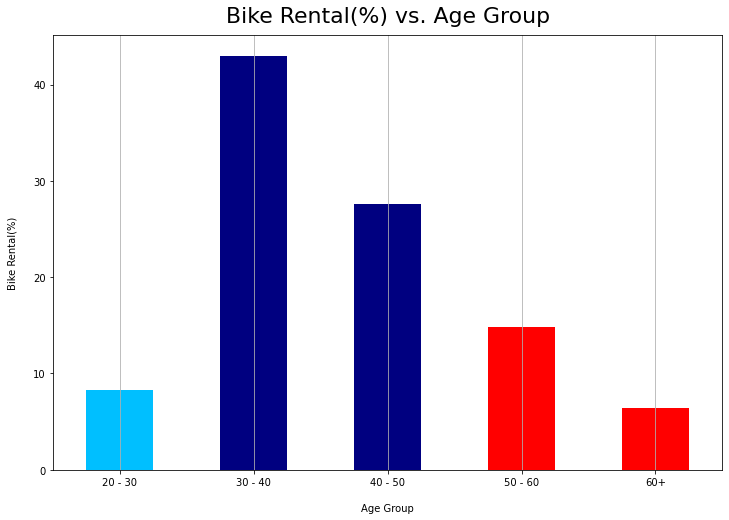

In [0]:
df_trip_by_age = df1_pandas.groupby('member_age_bins').agg({'bike_id':'count'})
df_trip_by_age['perc'] = (df_trip_by_age['bike_id'] / df_trip_by_age['bike_id'].sum())*100

plt_trip_by_age = ['deepskyblue', 'navy', 'navy', 'red', 'red']
df_trip_by_age['perc'].plot(kind='bar', color=plt_trip_by_age, figsize=(12,8))
plt.title('Bike Rental(%) vs. Age Group', fontsize=22, y=1.015)
plt.xlabel('Age Group', labelpad=16)
plt.ylabel('Bike Rental(%)', labelpad=16)

ax = plt.gca()
ax.xaxis.grid()

plt.xticks(rotation=0);

In [0]:
df_trip_by_age

,bike_id,perc
member_age_bins,,
20 - 30,37319,8.235299
30 - 40,194881,43.004994
40 - 50,124940,27.570897
50 - 60,66979,14.780463
60+,29040,6.408347


#### From the above graph we can notice that the age people who ride mostly bikes are between the age group of 30 and 40 as they account for the than 40% of the total number of rides

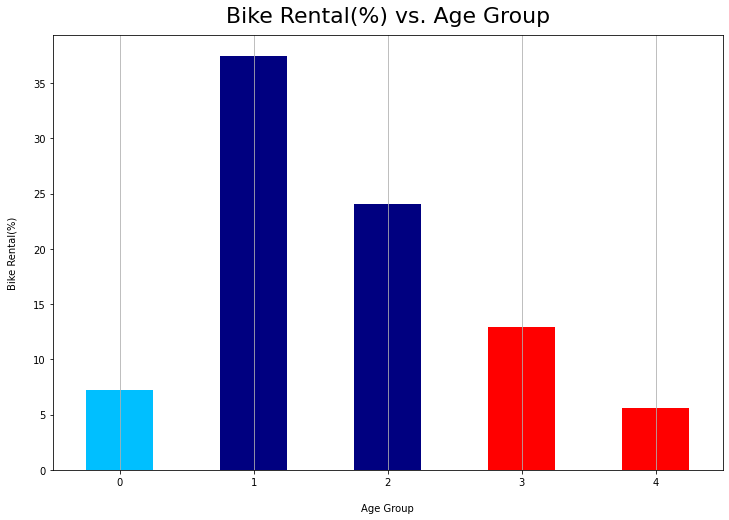

In [0]:
from pyspark.sql.functions import sum
df_trip_by_age = df1.groupBy('member_age_bins').agg({'bike_id':'count'}).orderBy('member_age_bins')
df_trip_by_age= df_trip_by_age.withColumn('perc', (df_trip_by_age['count(bike_id)'] / total_count)*100) 
df_trip_by_age = df_trip_by_age.select('*').toPandas()
plt_trip_by_age = ['deepskyblue', 'navy', 'navy', 'red', 'red']
df_trip_by_age['perc'].plot(kind='bar', x=df_trip_by_age['member_age_bins'] , color=plt_trip_by_age, figsize=(12,8))
plt.title('Bike Rental(%) vs. Age Group', fontsize=22, y=1.015)
plt.xlabel('Age Group', labelpad=16)
plt.ylabel('Bike Rental(%)', labelpad=16)

ax = plt.gca()
ax.xaxis.grid()

plt.xticks(rotation=0);

##### Result observed working more with pyspark

## Age group vs Trip distance

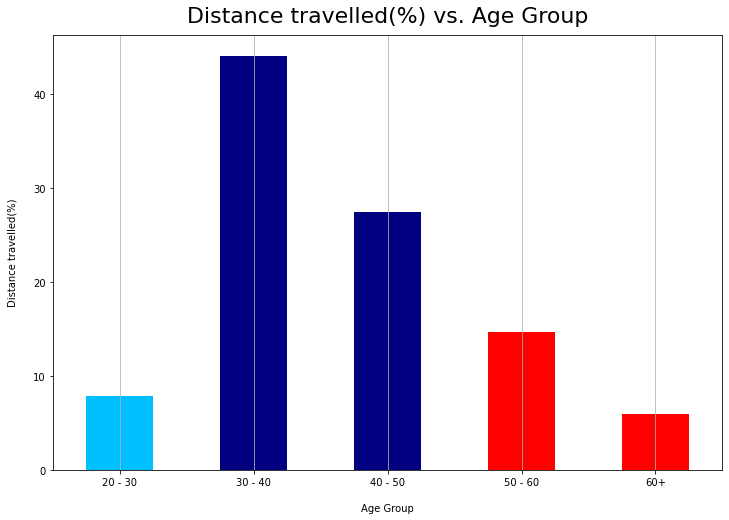

In [0]:
df_dist_by_age = df1_pandas.groupby('member_age_bins').agg({'distance_travelled':'sum'})
df_dist_by_age['perc'] = (df_dist_by_age['distance_travelled'] / df_dist_by_age['distance_travelled'].sum())*100

plt_dist_by_age = ['deepskyblue', 'navy', 'navy', 'red', 'red']
df_dist_by_age['perc'].plot(kind='bar', color=plt_trip_by_age, figsize=(12,8))
plt.title('Distance travelled(%) vs. Age Group', fontsize=22, y=1.015)
plt.xlabel('Age Group', labelpad=16)
plt.ylabel('Distance travelled(%)', labelpad=16)

ax = plt.gca()
ax.xaxis.grid()

plt.xticks(rotation=0);

In [0]:
df_dist_by_age

,distance_travelled,perc
member_age_bins,,
20 - 30,56873.22,7.847389
30 - 40,319482.75,44.082354
40 - 50,199003.40,27.458566
50 - 60,106003.50,14.626404
60+,43377.81,5.985287


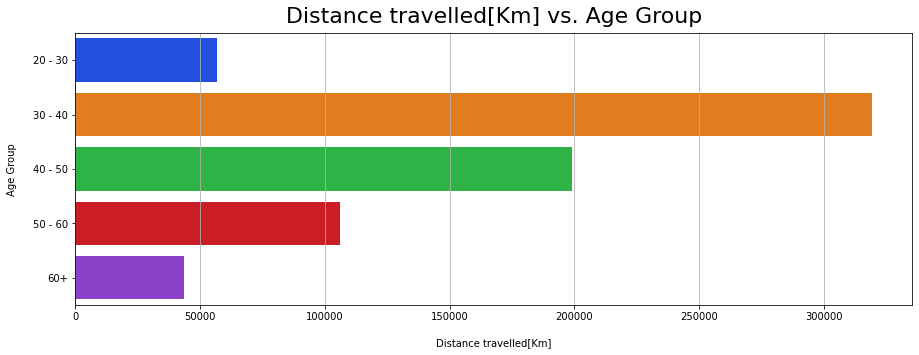

In [0]:
plt.figure(figsize=(15,5))
df_dist_by_age = df1_pandas.groupby('member_age_bins').agg({'distance_travelled':'sum'})
df_dist_by_age['perc'] = (df_dist_by_age['distance_travelled'] / df_dist_by_age['distance_travelled'].sum())*100

plt_dist_by_age = ['deepskyblue', 'navy', 'navy', 'red', 'red']
sns.barplot(data=df_dist_by_age ,y=df_dist_by_age.index,x=df_dist_by_age['distance_travelled'],palette='bright')#, color=plt_trip_by_age)# figsize=(12,8))
plt.title('Distance travelled[Km] vs. Age Group', fontsize=22, y=1.015)
plt.ylabel('Age Group', labelpad=16)
plt.xlabel('Distance travelled[Km]', labelpad=16)

ax = plt.gca()
ax.xaxis.grid()

plt.xticks(rotation=0);

In [0]:
df_dist_by_age

,distance_travelled,perc
member_age_bins,,
20 - 30,56873.22,7.847389
30 - 40,319482.75,44.082354
40 - 50,199003.40,27.458566
50 - 60,106003.50,14.626404
60+,43377.81,5.985287


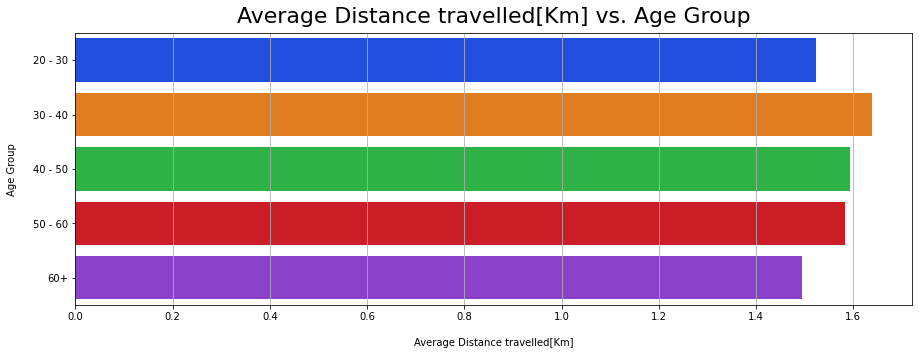

In [0]:
plt.figure(figsize=(15,5))
df_dist_by_age = df1_pandas.groupby('member_age_bins').agg({'distance_travelled':'mean'})
#df_dist_by_age['perc'] = (df_dist_by_age['distance_travelled'] / df_dist_by_age['distance_travelled'].mean())*100

plt_dist_by_age = ['deepskyblue', 'navy', 'navy', 'red', 'red']
sns.barplot(data=df_dist_by_age ,y=df_dist_by_age.index,x=df_dist_by_age['distance_travelled'],palette='bright')#, color=plt_trip_by_age)# figsize=(12,8))
plt.title('Average Distance travelled[Km] vs. Age Group', fontsize=22, y=1.015)
plt.ylabel('Age Group', labelpad=16)
plt.xlabel('Average Distance travelled[Km]', labelpad=16)

ax = plt.gca()
ax.xaxis.grid()

plt.xticks(rotation=0);

In [0]:
df_dist_by_age

,distance_travelled
member_age_bins,
20 - 30,1.523975
30 - 40,1.639374
40 - 50,1.592792
50 - 60,1.582638
60+,1.493726


##### From the above we can observe that the age group 30-40 overall appears to account for most distance travelled again here too

In [0]:
Top_ten_dist_age = df1.groupBy('member_age').agg({'distance_travelled':'mean'}).orderBy('avg(distance_travelled)', ascending=False).limit(10)
Top_ten_dist_age = Top_ten_dist_age.select("*").toPandas()

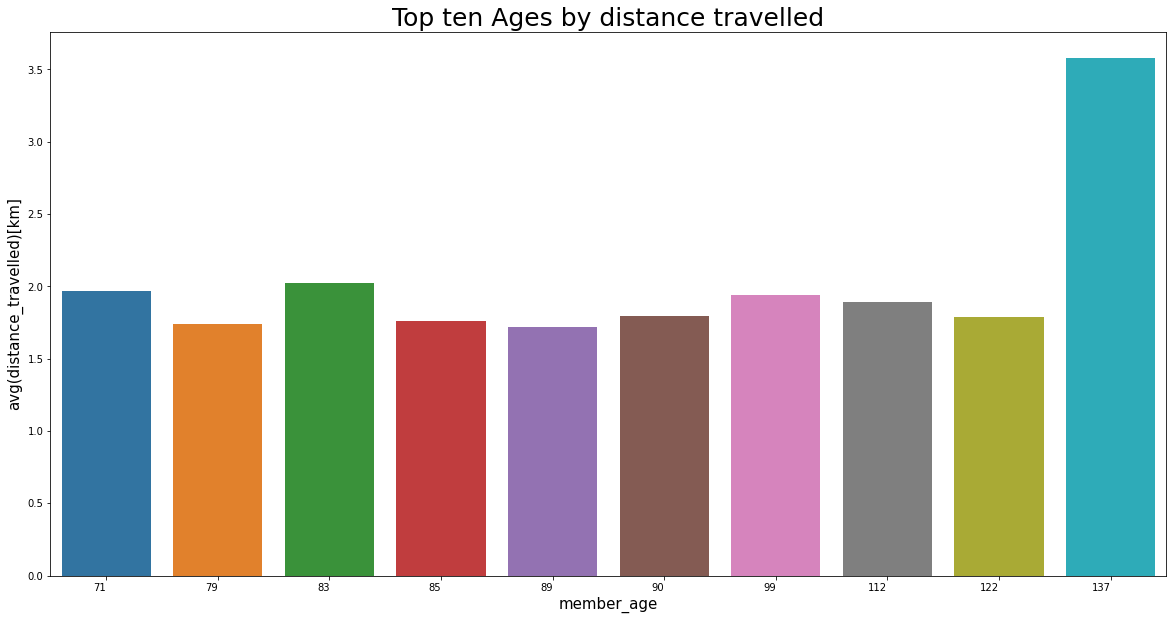

In [0]:
plt.figure(figsize=(20,10))
graph = sns.barplot(x = Top_ten_dist_age['member_age'], y = Top_ten_dist_age['avg(distance_travelled)'], palette= "tab10")
graph.set_title("Top ten Ages by distance travelled", fontsize = 25)
plt.xlabel('member_age', size=15)
plt.ylabel('avg(distance_travelled)[km]', size=15)
graph.set_xticklabels(graph.get_xticklabels(), rotation= 0, horizontalalignment='right',);

In [0]:
Top_ten_dist_age

,member_age,avg(distance_travelled)
0,137,3.580000
1,83,2.024138
2,71,1.966396
3,99,1.938182
4,112,1.890833
5,90,1.795610
6,122,1.785000
7,85,1.757273
8,79,1.738658
9,89,1.717059


##### It is important to notice here too that people who are old appear to be travelling the longest distance too

## Age group vs UserType

In [0]:
user_type_age = df1.groupBy(['user_type','member_age_bins']).agg({'user_type':'count'}).orderBy('user_type','member_age_bins').select('*').toPandas()

In [0]:
user_type_age

,user_type,member_age_bins,count(user_type)
0,Customer,20 - 30,7007
1,Customer,30 - 40,24376
2,Customer,40 - 50,10899
3,Customer,50 - 60,4754
4,Customer,60+,1699
5,Subscriber,20 - 30,30312
6,Subscriber,30 - 40,170505
7,Subscriber,40 - 50,114041
8,Subscriber,50 - 60,62225
9,Subscriber,60+,27341


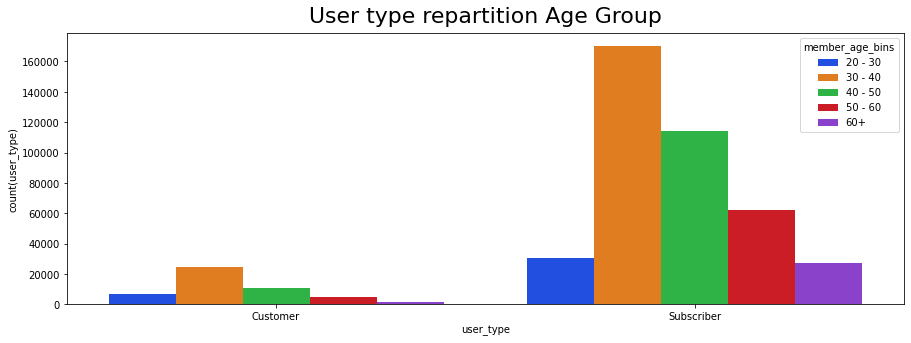

In [0]:
plt.figure(figsize=(15,5))
sns.barplot(data=user_type_age, x=user_type_age['user_type'], y= user_type_age['count(user_type)'], hue='member_age_bins',
               palette='bright')
plt.title('User type repartition Age Group', fontsize=22, y=1.015)
plt.show()

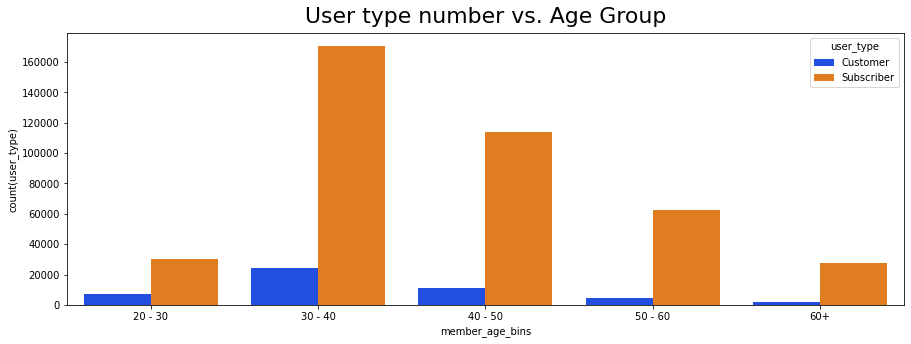

In [0]:
plt.figure(figsize=(15,5))
sns.barplot(data=user_type_age, x=user_type_age['member_age_bins'], y= user_type_age['count(user_type)'], hue='user_type',
               palette='bright')
plt.title('User type number vs. Age Group', fontsize=22, y=1.015)
plt.show()

##### It is important to note that overall Subscribers are more than customers and in both categories the age group 30-40 appears to be dominant as well

## Age group vs trip duration

In [0]:
trip_duration_age = df1.groupBy(['member_age_bins']).agg({'trip_duration_minutes':'mean'}).orderBy('member_age_bins').select('*').toPandas()

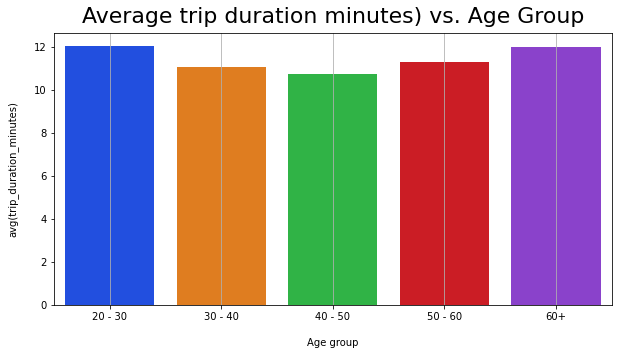

In [0]:
plt.figure(figsize=(10,5))
sns.barplot(data=trip_duration_age, x=trip_duration_age['member_age_bins'], y= trip_duration_age['avg(trip_duration_minutes)'],palette='bright')
plt.ylabel('avg(trip_duration_minutes)', labelpad=16)
plt.xlabel('Age group', labelpad=16)

ax = plt.gca()
ax.xaxis.grid()
plt.title('Average trip duration minutes) vs. Age Group', fontsize=22, y=1.015)
plt.xticks(rotation=0)
plt.show()

In [0]:
trip_duration_age

,member_age_bins,avg(trip_duration_minutes)
0,20 - 30,12.038827
1,30 - 40,11.068729
2,40 - 50,10.739435
3,50 - 60,11.271697
4,60+,12.011639


In [0]:
trip_duration_age = df1.groupBy(['member_age_bins']).agg({'trip_duration_minutes':'sum'}).orderBy('member_age_bins').select('*').toPandas()

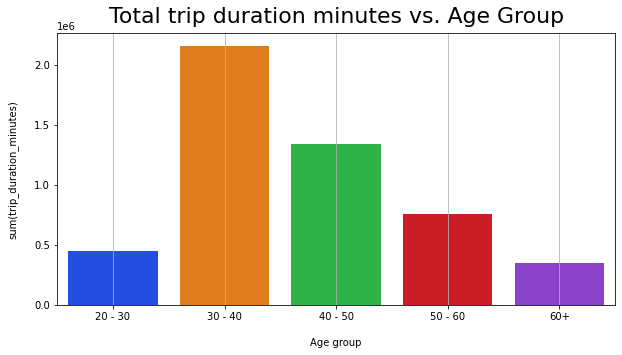

In [0]:
plt.figure(figsize=(10,5))
sns.barplot(data=trip_duration_age, x=trip_duration_age['member_age_bins'], y= trip_duration_age['sum(trip_duration_minutes)'],palette='bright')
plt.ylabel('sum(trip_duration_minutes)', labelpad=16)
plt.xlabel('Age group', labelpad=16)

ax = plt.gca()
ax.xaxis.grid()
plt.title('Total trip duration minutes vs. Age Group', fontsize=22, y=1.015)

plt.xticks(rotation=0)
plt.show()

In [0]:
trip_duration_age

,member_age_bins,sum(trip_duration_minutes)
0,20 - 30,449277.0
1,30 - 40,2157085.0
2,40 - 50,1341785.0
3,50 - 60,754967.0
4,60+,348818.0


##### On average all the age groups appera to be having almost the same trip duration but the youger and the old people having slightly more. Also the group 30-40 appers to have the highest duration overall and this makes sense becaause it has the highest number of riders

## Age group vs revenues

In [0]:
revenue_by_age = df1.groupBy(['member_age_bins']).agg({'trip_fee(cents)':'mean'}).orderBy('member_age_bins').select('*').toPandas()

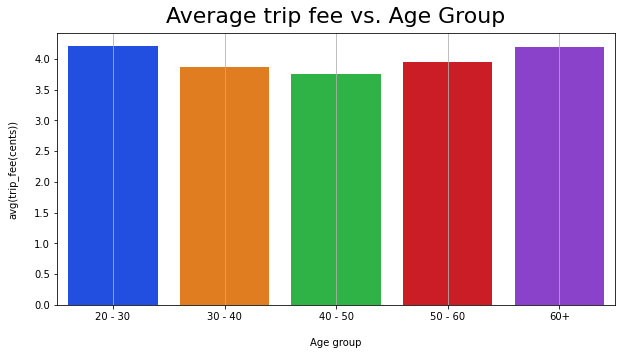

In [0]:
plt.figure(figsize=(10,5))
sns.barplot(data=revenue_by_age, x=revenue_by_age['member_age_bins'], y= revenue_by_age['avg(trip_fee(cents))'],palette='bright')
plt.ylabel('avg(trip_fee(cents))', labelpad=16)
plt.xlabel('Age group', labelpad=16)

ax = plt.gca()
ax.xaxis.grid()
plt.title('Average trip fee vs. Age Group', fontsize=22, y=1.015)

plt.xticks(rotation=0)
plt.show()

In [0]:
revenue_by_age

,member_age_bins,avg(trip_fee(cents))
0,20 - 30,4.213590
1,30 - 40,3.874055
2,40 - 50,3.758802
3,50 - 60,3.945094
4,60+,4.204074


In [0]:
revenue_by_age = df1.groupBy(['member_age_bins']).agg({'trip_fee(cents)':'sum'}).orderBy('member_age_bins').select('*').toPandas()

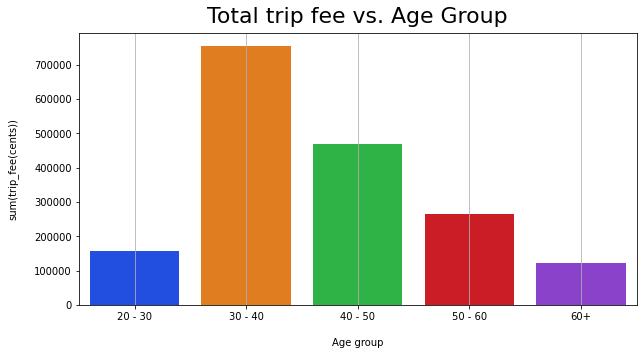

In [0]:
plt.figure(figsize=(10,5))
sns.barplot(data=revenue_by_age, x=revenue_by_age['member_age_bins'], y= revenue_by_age['sum(trip_fee(cents))'],palette='bright')
plt.ylabel('sum(trip_fee(cents))', labelpad=16)
plt.xlabel('Age group', labelpad=16)

ax = plt.gca()
ax.xaxis.grid()
plt.title('Total trip fee vs. Age Group', fontsize=22, y=1.015)

plt.xticks(rotation=0)
plt.show()

In [0]:
revenue_by_age

,member_age_bins,sum(trip_fee(cents))
0,20 - 30,157246.95
1,30 - 40,754979.75
2,40 - 50,469624.75
3,50 - 60,264238.45
4,60+,122086.30


##### The revenue being connected to the trip duration the same pattern can clearly observed here too with the biggest source of revenues being the age group 30-40. Also the youngest and the oldest people appear to be spending more compared to others on average

# Gender Analysis

## Bike rentals vs Gender

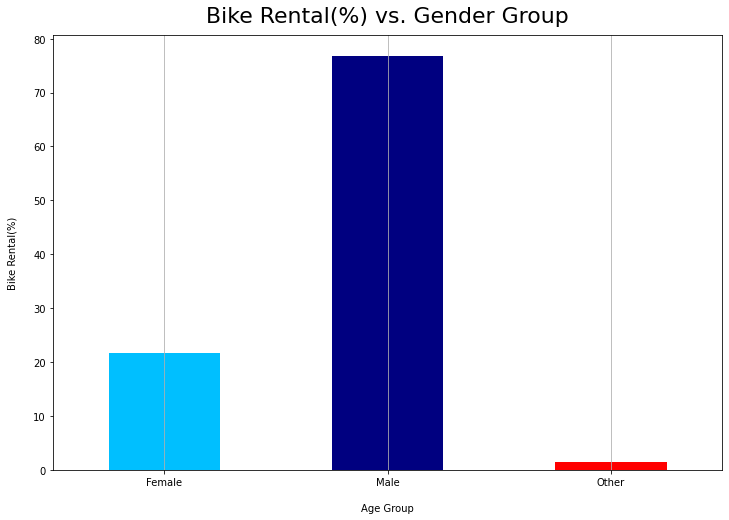

In [0]:
df_trip_by_age = df1_pandas.groupby('member_gender').agg({'bike_id':'count'})
df_trip_by_age['perc'] = (df_trip_by_age['bike_id'] / df_trip_by_age['bike_id'].sum())*100

plt_trip_by_age = ['deepskyblue', 'navy', 'red', 'red']
df_trip_by_age['perc'].plot(kind='bar', color=plt_trip_by_age, figsize=(12,8))
plt.title('Bike Rental(%) vs. Gender Group', fontsize=22, y=1.015)
plt.xlabel('Age Group', labelpad=16)
plt.ylabel('Bike Rental(%)', labelpad=16)

ax = plt.gca()
ax.xaxis.grid()

plt.xticks(rotation=0);

## Trip distance vs Gender

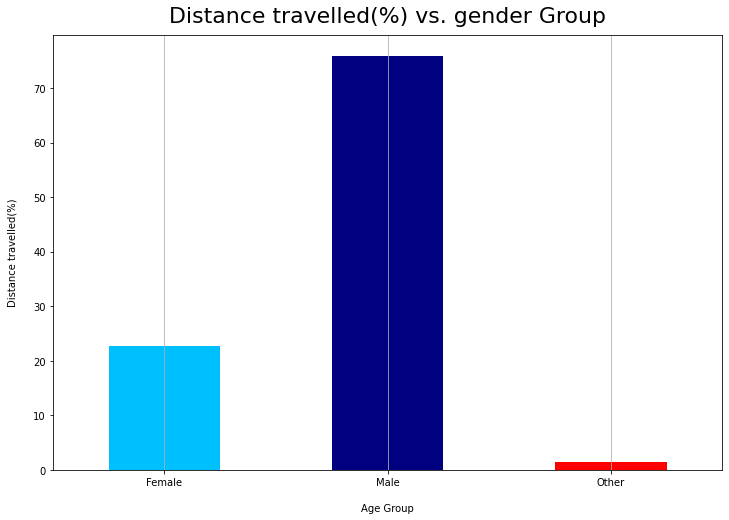

In [0]:
df_dist_by_age = df1_pandas.groupby('member_gender').agg({'distance_travelled':'sum'})
df_dist_by_age['perc'] = (df_dist_by_age['distance_travelled'] / df_dist_by_age['distance_travelled'].sum())*100

plt_dist_by_age = ['deepskyblue', 'navy',  'red', 'red']
df_dist_by_age['perc'].plot(kind='bar', color=plt_trip_by_age, figsize=(12,8))
plt.title('Distance travelled(%) vs. gender Group', fontsize=22, y=1.015)
plt.xlabel('Age Group', labelpad=16)
plt.ylabel('Distance travelled(%)', labelpad=16)

ax = plt.gca()
ax.xaxis.grid()

plt.xticks(rotation=0);

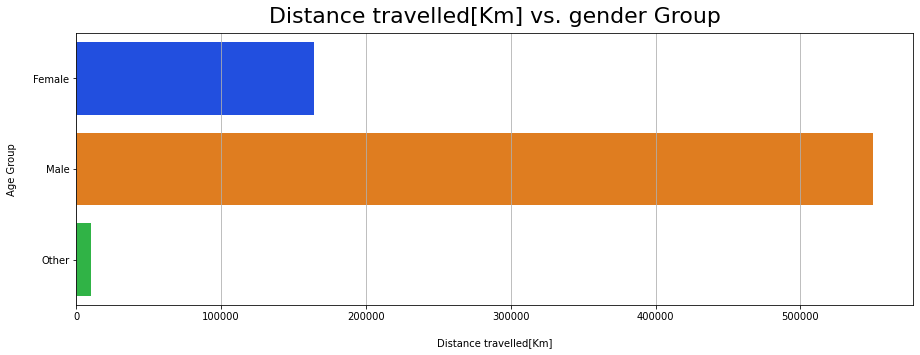

In [0]:
plt.figure(figsize=(15,5))
df_dist_by_age = df1_pandas.groupby('member_gender').agg({'distance_travelled':'sum'})
df_dist_by_age['perc'] = (df_dist_by_age['distance_travelled'] / df_dist_by_age['distance_travelled'].sum())*100

plt_dist_by_age = ['deepskyblue', 'navy', 'navy', 'red', 'red']
sns.barplot(data=df_dist_by_age ,y=df_dist_by_age.index,x=df_dist_by_age['distance_travelled'],palette='bright')#, color=plt_trip_by_age)# figsize=(12,8))
plt.title('Distance travelled[Km] vs. gender Group', fontsize=22, y=1.015)
plt.ylabel('Age Group', labelpad=16)
plt.xlabel('Distance travelled[Km]', labelpad=16)

ax = plt.gca()
ax.xaxis.grid()

plt.xticks(rotation=0);

## Gender vs user_type

In [0]:
user_type_age = df1.groupBy(['user_type','member_gender']).agg({'user_type':'count'}).orderBy('user_type','member_gender').select('*').toPandas()

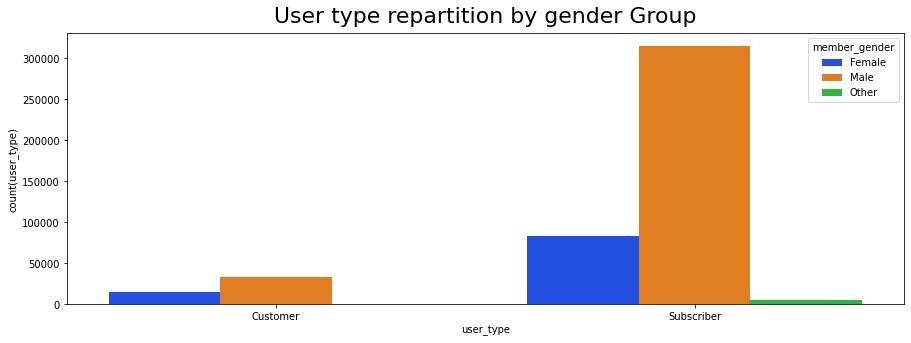

In [0]:
plt.figure(figsize=(15,5))
sns.barplot(data=user_type_age, x=user_type_age['user_type'], y= user_type_age['count(user_type)'], hue='member_gender',
               palette='bright')
plt.title('User type repartition by gender Group', fontsize=22, y=1.015)
plt.show()

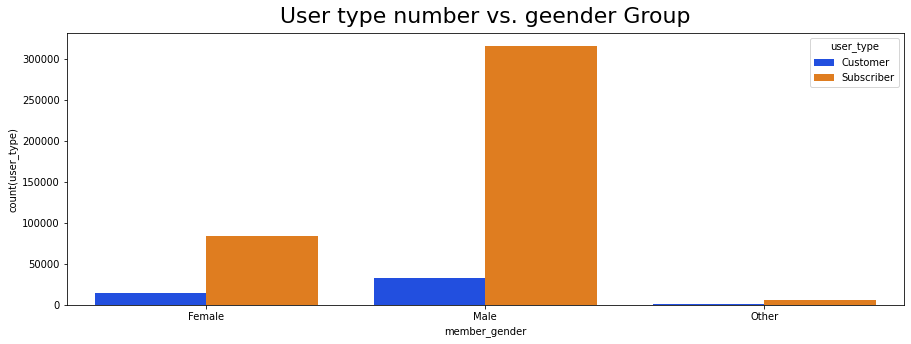

In [0]:
plt.figure(figsize=(15,5))
sns.barplot(data=user_type_age, x=user_type_age['member_gender'], y= user_type_age['count(user_type)'], hue='user_type',
               palette='bright')
plt.title('User type number vs. geender Group', fontsize=22, y=1.015)
plt.show()

#### Male riders being more that female riders and the subscribers being more than customers than for sure male will be occupying tha largest part of subscribers for sure

## Gender vs revenues

In [0]:
revenue_by_age = df1.groupBy(['member_gender']).agg({'trip_fee(cents)':'mean'}).orderBy('member_gender').select('*').toPandas()

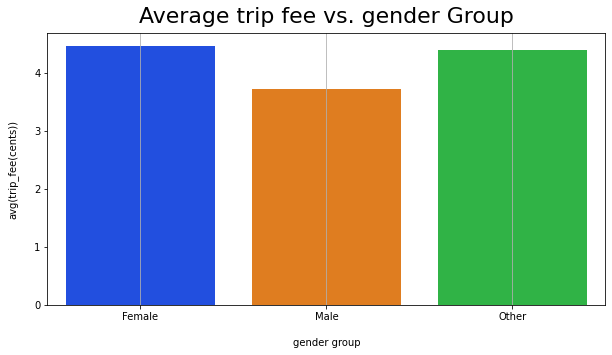

In [0]:
plt.figure(figsize=(10,5))
sns.barplot(data=revenue_by_age, x=revenue_by_age['member_gender'], y= revenue_by_age['avg(trip_fee(cents))'],palette='bright')
plt.ylabel('avg(trip_fee(cents))', labelpad=16)
plt.xlabel('gender group', labelpad=16)

ax = plt.gca()
ax.xaxis.grid()
plt.title('Average trip fee vs. gender Group', fontsize=22, y=1.015)

plt.xticks(rotation=0)
plt.show()

In [0]:
revenue_by_age = df1.groupBy(['member_gender']).agg({'trip_fee(cents)':'sum'}).orderBy('member_gender').select('*').toPandas()

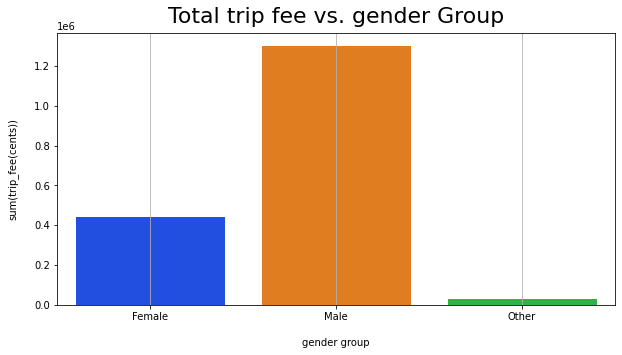

In [0]:
plt.figure(figsize=(10,5))
sns.barplot(data=revenue_by_age, x=revenue_by_age['member_gender'], y= revenue_by_age['sum(trip_fee(cents))'],palette='bright')
plt.ylabel('sum(trip_fee(cents))', labelpad=16)
plt.xlabel('gender group', labelpad=16)

ax = plt.gca()
ax.xaxis.grid()
plt.title('Total trip fee vs. gender Group', fontsize=22, y=1.015)

plt.xticks(rotation=0)
plt.show()

#### On average female riders spend more than males riders----Verry intersting discovery

## Gender vs age group

In [0]:
user_type_age = df1.groupBy(['member_gender','member_age_bins']).agg({'member_gender':'count'}).orderBy('member_gender','member_age_bins').select('*').toPandas()

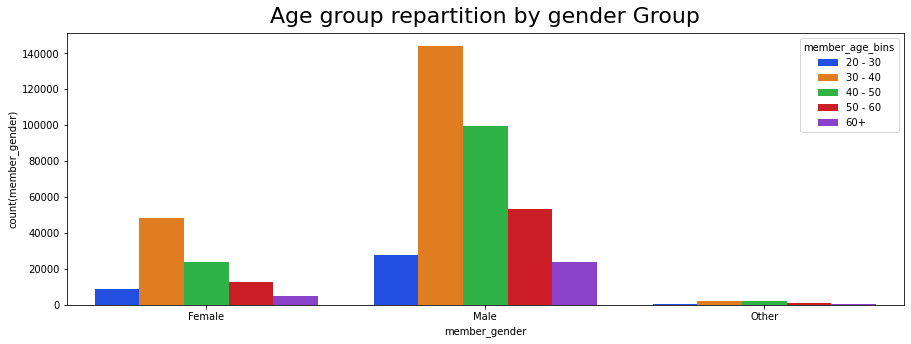

In [0]:
plt.figure(figsize=(15,5))
sns.barplot(data=user_type_age, x=user_type_age['member_gender'], y= user_type_age['count(member_gender)'], hue='member_age_bins',
               palette='bright')
plt.title('Age group repartition by gender Group', fontsize=22, y=1.015)
plt.show()

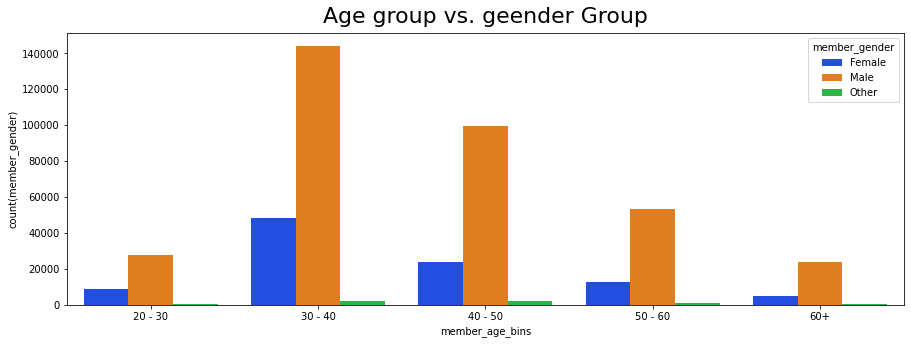

In [0]:
plt.figure(figsize=(15,5))
sns.barplot(data=user_type_age, x=user_type_age['member_age_bins'], y= user_type_age['count(member_gender)'], hue='member_gender',
               palette='bright')
plt.title('Age group vs. geender Group', fontsize=22, y=1.015)
plt.show()

#### Top poin tout at the earlier discoveries we notice that the mots popular age group 30-40 appears to be topping in both the male and female categories as well

# Exploring the most pupolar stations

In [0]:
Top_ten_stations = df1.groupBy('start_station_id').agg({'bike_id':'count'}).orderBy('count(bike_id)', ascending=False).limit(10)
Top_ten_stations = Top_ten_stations.select("*").toPandas()

In [0]:
Top_ten_stations

,start_station_id,count(bike_id)
0,30,11929
1,67,11627
2,15,11507
3,58,10910
4,81,10140
5,21,10041
6,22,9569
7,6,9501
8,16,8369
9,3,7902


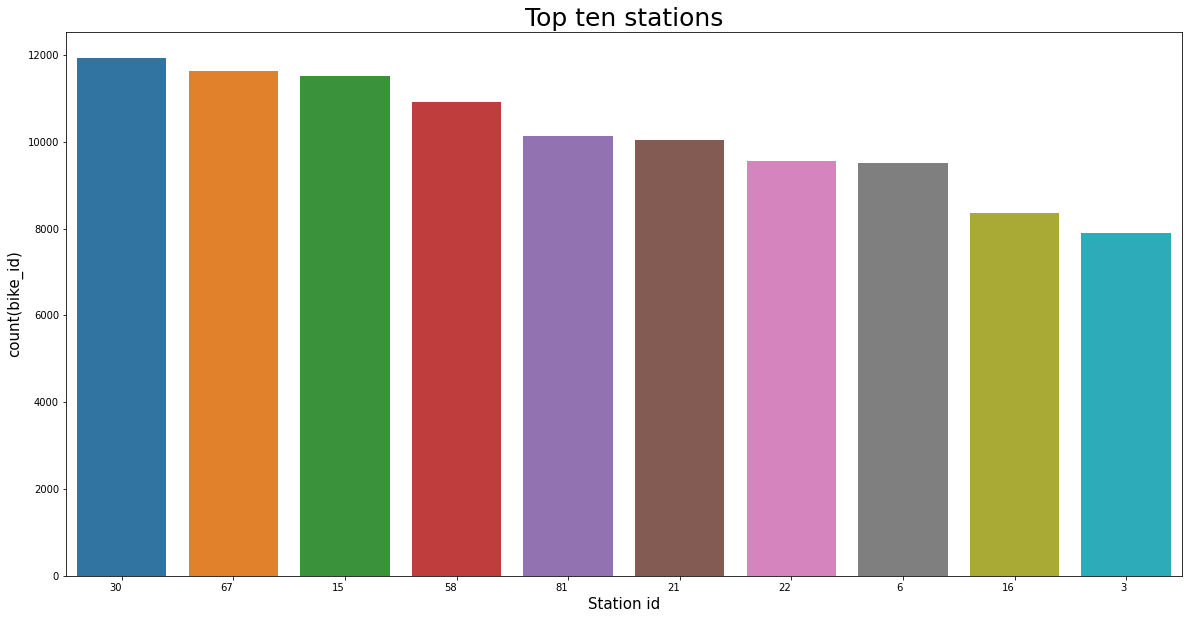

In [0]:
plt.figure(figsize=(20,10))
graph = sns.barplot(x = Top_ten_stations['start_station_id'], y = Top_ten_stations['count(bike_id)'], palette= "tab10")
graph.set_title("Top ten stations", fontsize = 25)
plt.xlabel('Station id', size=15)
plt.ylabel('count(bike_id)', size=15)
graph.set_xticklabels(graph.get_xticklabels(), rotation= 0, horizontalalignment='right',);

In [0]:
df1.printSchema()

root
 |-- start_time: timestamp (nullable = true)
 |-- end_time: timestamp (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: double (nullable = true)
 |-- start_station_longitude: double (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: double (nullable = true)
 |-- end_station_longitude: double (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: string (nullable = true)
 |-- member_gender: string (nullable = true)
 |-- pyment: string (nullable = true)
 |-- distance_travelled: double (nullable = true)
 |-- trip_duration_seconds: long (nullable = true)
 |-- trip_duration_minutes: double (nullable = true)
 |-- trip_fee(cents): double (nullable = true)
 |-- member_age: integer (nullable = true)
 |-- member_age_bins: string (nullable = true

In [0]:
Top_ten_stations = df1.groupBy('start_station_id').agg({'bike_id':'count'}).orderBy('count(bike_id)', ascending=False).limit(10)


In [0]:
Top_ten_stations.show()

+----------------+--------------+
|start_station_id|count(bike_id)|
+----------------+--------------+
|              30|         11929|
|              67|         11627|
|              15|         11507|
|              58|         10910|
|              81|         10140|
|              21|         10041|
|              22|          9569|
|               6|          9501|
|              16|          8369|
|               3|          7902|
+----------------+--------------+



In [0]:
Top_station = Top_ten_stations.collect()[:]

In [0]:
Top_stations = [row[0] for row in Top_station]

In [0]:
Top_stations

Out[127]: ['30', '67', '15', '58', '81', '21', '22', '6', '16', '3']

In [0]:
top_station_df = df1.filter(df1['start_station_id'].isin(Top_stations))

## Top ten sations vs gender

In [0]:
top_ten_stat = top_station_df.groupBy(['start_station_id','member_gender']).agg({'member_gender':'count'}).orderBy('member_gender').toPandas()

In [0]:
top_ten_stat

,start_station_id,member_gender,count(member_gender)
0,30,Female,2035
1,67,Female,2105
2,15,Female,2817
3,21,Female,1631
4,81,Female,2302
5,58,Female,1870
6,16,Female,1740
7,22,Female,1943
8,6,Female,1938
9,3,Female,1768


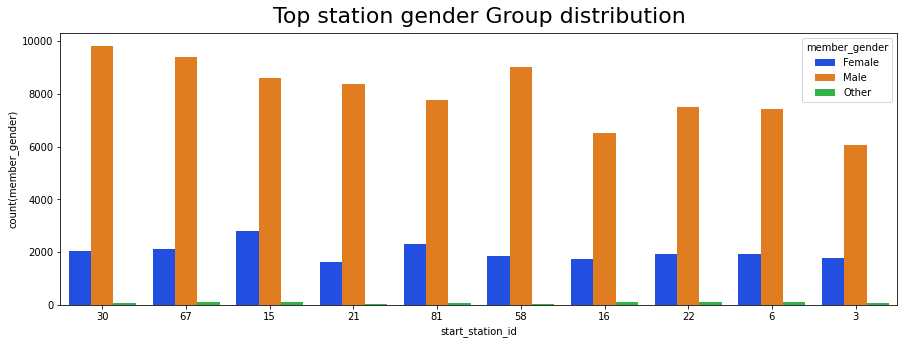

In [0]:
plt.figure(figsize=(15,5))
sns.barplot(data=top_ten_stat, x=top_ten_stat['start_station_id'], y= top_ten_stat['count(member_gender)'], hue='member_gender',
               palette='bright')
plt.title('Top station gender Group distribution', fontsize=22, y=1.015)
plt.show()

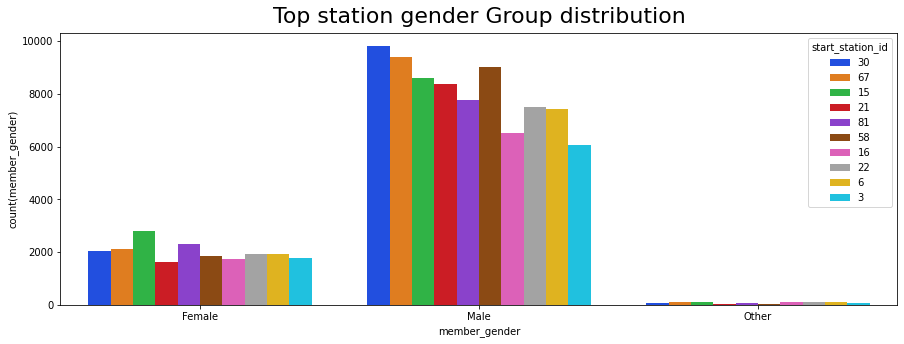

In [0]:
plt.figure(figsize=(15,5))
sns.barplot(data=top_ten_stat, x=top_ten_stat['member_gender'], y= top_ten_stat['count(member_gender)'], hue='start_station_id',
               palette='bright')
plt.title('Top station gender Group distribution', fontsize=22, y=1.015)
plt.show()

#### From the above figure we can easily see that the male gender are most people frequenting the most pouplar station. And this makes ens because most riders are male and meaqning they will be the one frequenting this
#### We can also notice that Most male riders are using station 30 while most female are using station 15

### Top station vs age groups

In [0]:
top_ten_stat_age = top_station_df.groupBy(['start_station_id','member_age_bins']).agg({'member_age_bins':'count'}).orderBy('member_age_bins').toPandas()

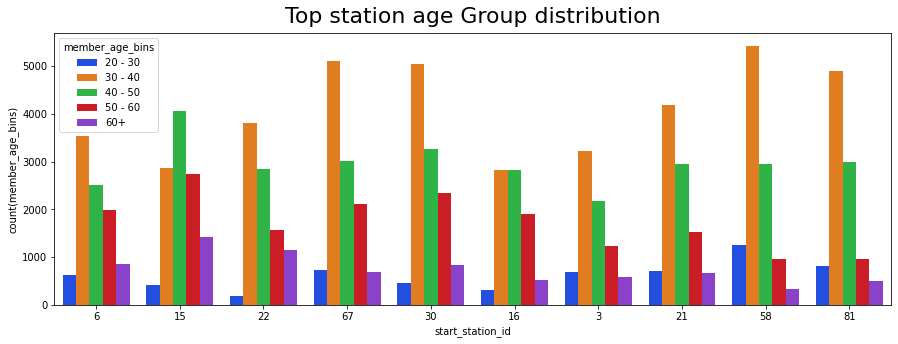

In [0]:
plt.figure(figsize=(15,5))
sns.barplot(data=top_ten_stat_age, x=top_ten_stat_age['start_station_id'], y= top_ten_stat_age['count(member_age_bins)'], hue='member_age_bins',
               palette='bright')
plt.title('Top station age Group distribution', fontsize=22, y=1.015)
plt.show()

##### The most popular age group 30-40 appears to be frequenting ,ost of the stations escept just  on station 15

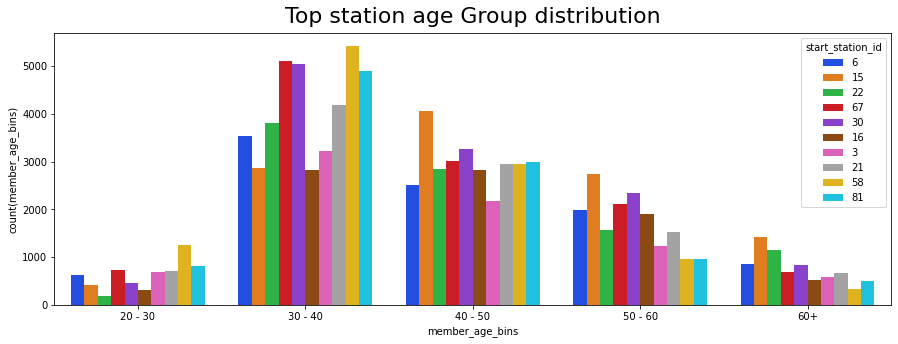

In [0]:
plt.figure(figsize=(15,5))
sns.barplot(data=top_ten_stat_age, x=top_ten_stat_age['member_age_bins'], y= top_ten_stat_age['count(member_age_bins)'], hue='start_station_id',
               palette='bright')
plt.title('Top station age Group distribution', fontsize=22, y=1.015)
plt.show()

# User type analysis

## Bike Rides Avg Trip Duration & Distance - Customers vs. Subscribers

Average Ride Duration - Customers: 17.34 mins, Subscribers: 10.40 mins
Average Ride Distance - Customers: 1.80 Km, Subscribers: 1.58 Km


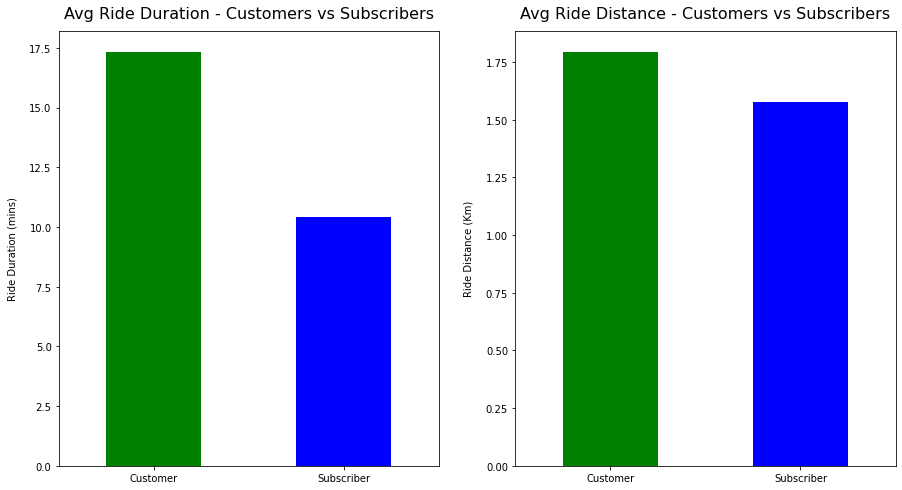

In [0]:
### Average trip duration by user types
plt.figure(figsize=(15, 8))
cplt_trip_usertypes=['green', 'blue']  ## customer, subscriber

xlabels = df1_pandas.user_type.unique()

plt.subplot(121)

df_duration_usertypes = df1_pandas.groupby('user_type')['trip_duration_minutes'].mean()  ## 'Series'

## Print average trip durations -
print("Average Ride Duration - Customers: {:2.2f} mins, Subscribers: {:2.2f} mins".format(
  df_duration_usertypes.Customer, df_duration_usertypes.Subscriber))

ax = df_duration_usertypes.plot(kind = 'bar', color=cplt_trip_usertypes)
## ax = df_duration_usertypes.plot(kind='bar', color=cplt_trip_usertypes, figsize=(12, 8))

ax.set_title('Avg Ride Duration - Customers vs Subscribers', fontsize = 16, y = 1.015)
ax.set_ylabel('Ride Duration (mins)', labelpad = 12)
ax.set_xlabel('User Type', labelpad=8).set_visible(False)
plt.xticks(rotation=360);


### Average trip duration by user types
plt.subplot(122)

df_distance_miles_usertypes = df1_pandas.groupby('user_type')['distance_travelled'].mean()

print("Average Ride Distance - Customers: {:2.2f} Km, Subscribers: {:2.2f} Km".format(
  df_distance_miles_usertypes.Customer, df_distance_miles_usertypes.Subscriber))

ax = df_distance_miles_usertypes.plot(kind = 'bar', color = cplt_trip_usertypes)
## ax = df_distance_miles_usertypes.plot(kind='bar', color=cplt_trip_usertypes, figsize=(12, 8))

ax.set_title('Avg Ride Distance - Customers vs Subscribers', fontsize=16, y=1.015)
ax.set_ylabel('Ride Distance (Km)', labelpad=12)
ax.set_xlabel('User Type', labelpad=8).set_visible(False)
plt.xticks(rotation=360);

#### Average trip duration for Customers is twice as long as that for Subscribers.
#### Travel distances by customers is roughly the same as those done by subscribers, 1.80 vs. 1.58 miles.

## user type vs bike rentals

Total bike rentals - Customers: 48735.00 , Subscribers: 404424.00 
Average trip fee - Customers: 6.07 cents, Subscribers: 3.64 cents


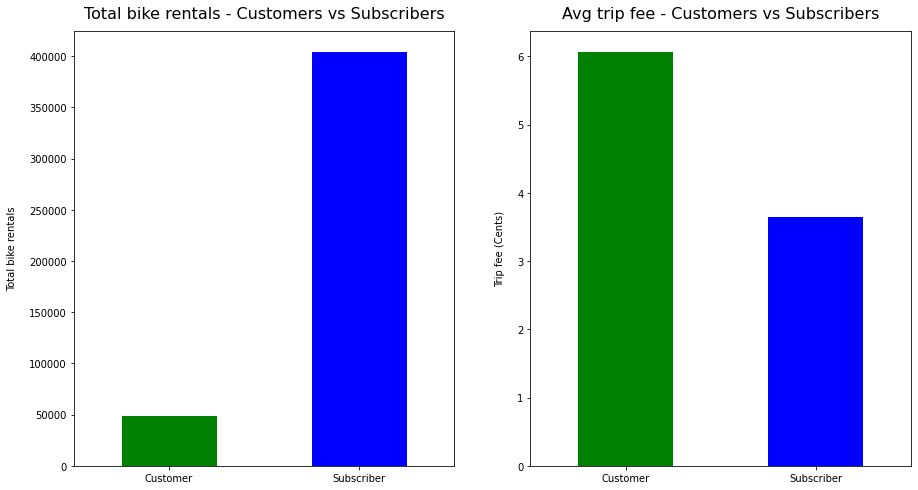

In [0]:
### Average trip duration by user types
plt.figure(figsize=(15, 8))
cplt_trip_usertypes=['green', 'blue']  ## customer, subscriber

xlabels = df1_pandas.user_type.unique()

plt.subplot(121)

df_rentals_usertypes = df1_pandas.groupby('user_type')['bike_id'].count()  ## 'Series'

## Print average trip durations -
print("Total bike rentals - Customers: {:2.2f} , Subscribers: {:2.2f} ".format(
  df_rentals_usertypes.Customer, df_rentals_usertypes.Subscriber))

ax = df_rentals_usertypes.plot(kind = 'bar', color=cplt_trip_usertypes)
## ax = df_duration_usertypes.plot(kind='bar', color=cplt_trip_usertypes, figsize=(12, 8))

ax.set_title('Total bike rentals - Customers vs Subscribers', fontsize = 16, y = 1.015)
ax.set_ylabel('Total bike rentals', labelpad = 12)
ax.set_xlabel('User Type', labelpad=8).set_visible(False)
plt.xticks(rotation=360);


### Average trip duration by user types
plt.subplot(122)

df_revenues_usertypes = df1_pandas.groupby('user_type')['trip_fee(cents)'].mean()

print("Average trip fee - Customers: {:2.2f} cents, Subscribers: {:2.2f} cents".format(
  df_revenues_usertypes.Customer, df_revenues_usertypes.Subscriber))

ax = df_revenues_usertypes.plot(kind = 'bar', color = cplt_trip_usertypes)
## ax = df_distance_miles_usertypes.plot(kind='bar', color=cplt_trip_usertypes, figsize=(12, 8))

ax.set_title('Avg trip fee - Customers vs Subscribers', fontsize=16, y=1.015)
ax.set_ylabel('Trip fee (Cents)', labelpad=12)
ax.set_xlabel('User Type', labelpad=8).set_visible(False)
plt.xticks(rotation=360);

#### The total bike rentals  for Customers is nine times as small as that for Subscribers.
#### The average trip fee spent by customers  is roughly the twice as that spent by subscribers, this makes sens as they spend on average much time

## user type vs age groups

In [0]:
user_type_by_age  = df1.groupBy(['user_type','member_age_bins']).agg({'member_age_bins':'count'}).orderBy('member_age_bins').toPandas()

In [0]:
user_type_by_age

,user_type,member_age_bins,count(member_age_bins)
0,Subscriber,20 - 30,30312
1,Customer,20 - 30,7007
2,Subscriber,30 - 40,170505
3,Customer,30 - 40,24376
4,Customer,40 - 50,10899
5,Subscriber,40 - 50,114041
6,Customer,50 - 60,4754
7,Subscriber,50 - 60,62225
8,Customer,60+,1699
9,Subscriber,60+,27341


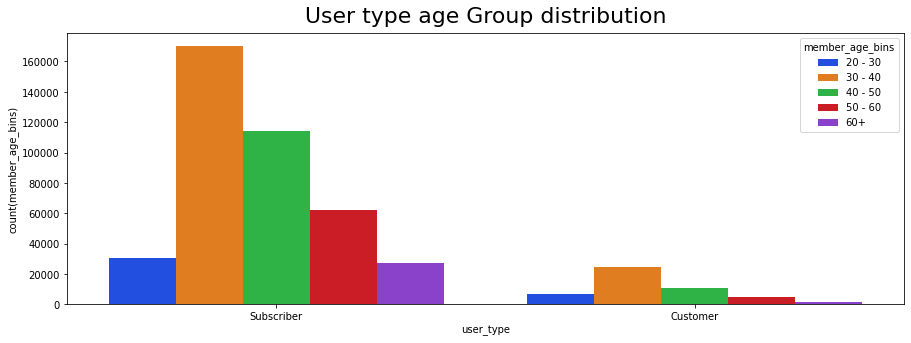

In [0]:
plt.figure(figsize=(15,5))
sns.barplot(data=user_type_by_age, x=user_type_by_age['user_type'], y= user_type_by_age['count(member_age_bins)'], hue='member_age_bins',
               palette='bright')
plt.title('User type age Group distribution', fontsize=22, y=1.015)
plt.show()

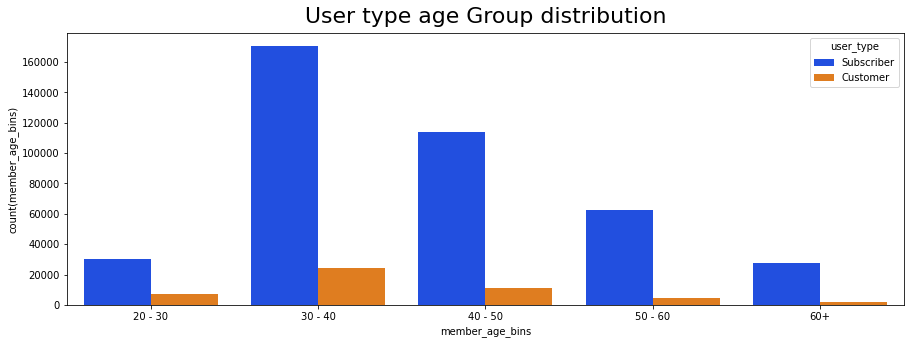

In [0]:
plt.figure(figsize=(15,5))
sns.barplot(data=user_type_by_age, x=user_type_by_age['member_age_bins'], y= user_type_by_age['count(member_age_bins)'], hue='user_type',
               palette='bright')
plt.title('User type age Group distribution', fontsize=22, y=1.015)
plt.show()

#### this makes sens with the most popular age group accounting for the highest cut in all the two user categories

## Distance vs age relation

<Figure size 1080x360 with 0 Axes>

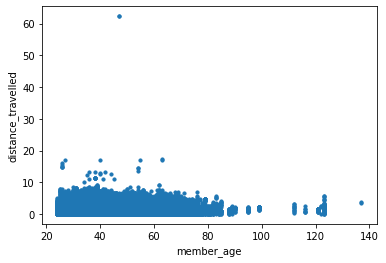

In [0]:
plt.figure(figsize=(15,5))
df1_pandas.plot.scatter(x='member_age', y='distance_travelled',s=10,colormap='viridis')
plt.show()

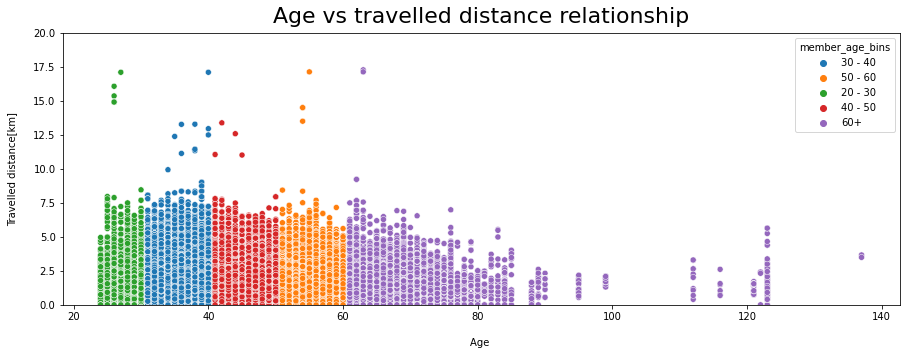

In [0]:
plt.figure(figsize=(15,5))
sns.scatterplot(data=df1_pandas,x='member_age', y='distance_travelled', hue="member_age_bins")
plt.title('Age vs travelled distance relationship', fontsize=22, y=1.015)
plt.xlabel('Age ', labelpad=16)
plt.ylabel('Travelled distance[km]', labelpad=16)
plt.ylim(0, 20)
plt.show()

#### From the above can't really derive a clear relationship between these two variables

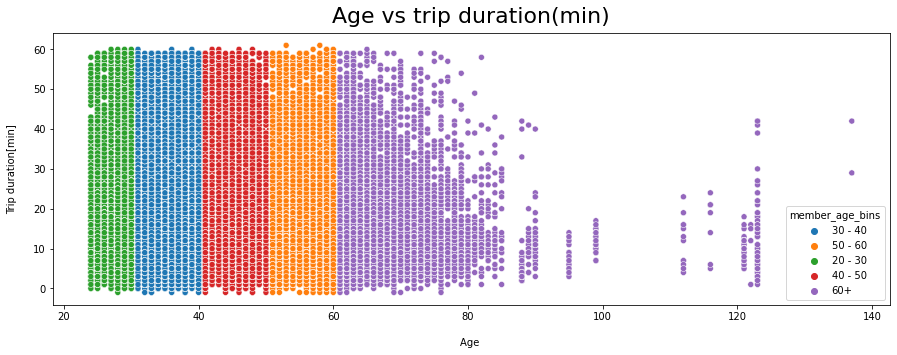

In [0]:
plt.figure(figsize=(15,5))
sns.scatterplot(data=df1_pandas,x='member_age', y='trip_duration_minutes', hue="member_age_bins")
plt.title('Age vs trip duration(min)', fontsize=22, y=1.015)
plt.xlabel('Age ', labelpad=16)
plt.ylabel('Trip duration[min]', labelpad=16)
#plt.ylim(0, 30)
plt.show()

#### Here we can hardly find a relationship between age and trip time too

In [0]:
df1.printSchema()

root
 |-- start_time: timestamp (nullable = true)
 |-- end_time: timestamp (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: double (nullable = true)
 |-- start_station_longitude: double (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: double (nullable = true)
 |-- end_station_longitude: double (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: string (nullable = true)
 |-- member_gender: string (nullable = true)
 |-- pyment: string (nullable = true)
 |-- distance_travelled: double (nullable = true)
 |-- trip_duration_seconds: long (nullable = true)
 |-- trip_duration_minutes: double (nullable = true)
 |-- trip_fee(cents): double (nullable = true)
 |-- member_age: integer (nullable = true)
 |-- member_age_bins: string (nullable = true